# Setup enviorment

In [1]:
%cd ..

/home/datascience/TOP 10 Municipalities Models


In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band7.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.969314 -0.849879 -0.930998 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.969314 -0.849879 -0.930998 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.969314 -0.849879 -0.930998 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.969314 -0.849879 -0.930998 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.969314 -0.849879 -0.930998 -1.0 -1.0 -1.0 -1.0   

                     9  ...  2039      2040     2041  2042  2043      2044  \
41001 201546 -0.955608  ...  -1.0 -0.855306 -0.89809  -1.0  -1.0 -0.807079   
      201547 -0.955608  ...  -1.0 -0.855306 -0.89809  -1.0  -1.0 -0.807079   
      201548 -0.955608  ...  -1.0 -0.855306 -0.89809  -1.0  -1.0 -0.807079   
      201549 -0.955608  ...  -1.0 -0.855306 -0.89809  -1.0  -1.0 -0.807079   
      201550 -0.955608  ...  -1.0 -0.855306 -0.89809  -1.0  -1.0 -0.807079   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.922165  -1.0 -0.861740  
      201547  -1.0 -0.922165  -1.0 -0.854589  
      201548  -1.0 -0.922165  -1.0 -0.856973  
      201549  -1.0 -0.922165  -1.0 -0.856973  
      201550  -1.0 -0.922165  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0    1         2         3         4    5         6    7    8  \
5360 201546 -1.0 -1.0 -0.969314 -0.849879 -0.930998 -1.0 -1.000000 -1.0 -1.0   
     201547 -1.0 -1.0 -0.527683 -1.000000 -1.000000 -1.0 -1.000000 -1.0 -1.0   
     201548 -1.0 -1.0 -0.969314 -0.849879 -0.930998 -1.0 -1.000000 -1.0 -1.0   
     201549 -1.0 -1.0 -0.715027 -1.000000 -0.841486 -1.0 -0.863248 -1.0 -1.0   
     201550 -1.0 -1.0 -0.969314 -0.849879 -0.930998 -1.0 -1.000000 -1.0 -1.0   

                    9  ...  2039      2040     2041  2042      2043      2044  \
5360 201546 -0.955608  ...  -1.0 -0.855306 -0.89809  -1.0 -1.000000 -0.807079   
     201547 -1.000000  ...  -1.0 -0.717353 -1.00000  -1.0 -0.965163 -1.000000   
     201548 -0.955608  ...  -1.0 -0.855306 -0.89809  -1.0 -1.000000 -0.807079   
     201549 -0.708851  ...  -1.0 -0.821930 -1.00000  -1.0 -0.874606 -0.907704   
     201550 -0.955608  ...  -1.0 -0.855306 -0.89809  -1.0 -1.000000 -0.807079   

             2045      2046      2047    Labels  
5360 201546  -1.0 -0.922165 -1.000000 -0.990465  
     201547  -1.0 -0.808931 -1.000000 -0.969011  
     201548  -1.0 -0.922165 -1.000000 -0.995232  
     201549  -1.0 -0.132205 -0.471784 -0.997616  
     201550  -1.0 -0.922165 -1.000000 -0.971395  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 2048)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 2048)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

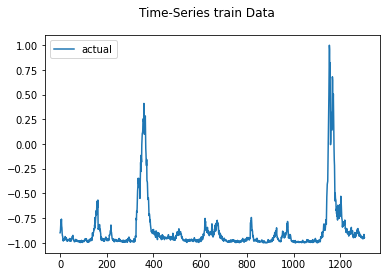

2023-03-06 15:14:58.968129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-06 15:14:58.968168: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-06 15:14:58.968192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-06 15:14:58.968402: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 15:14:59.035997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 127.630
Test RMSE: 146.839
Test sMAPE: 160.481
Test R Squared: -18.846
{'mae': 127.62962515112812, 'rmse': 146.83925572663804, 'smape': 160.48132967005708, 'r2': -18.845898475720332}


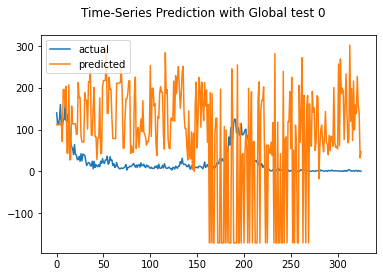

Test MAE: 92.794
Test RMSE: 127.098
Test sMAPE: 145.298
Test R Squared: -13.868
{'mae': 92.79442216218249, 'rmse': 127.09798582819445, 'smape': 145.2975134241144, 'r2': -13.868383439734927}


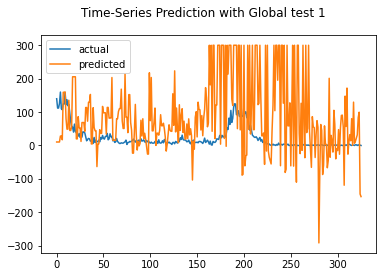

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 33.866
Test RMSE: 43.490
Test sMAPE: 125.960
Test R Squared: -0.741
{'mae': 33.86614114338635, 'rmse': 43.489991777161045, 'smape': 125.95952954716913, 'r2': -0.7408648934223152}


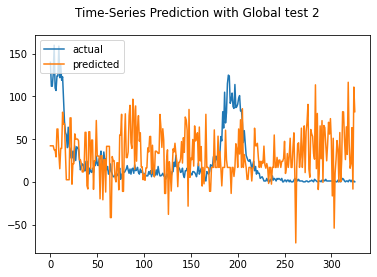

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 51.292
Test RMSE: 62.695
Test sMAPE: 149.648
Test R Squared: -2.618
{'mae': 51.29151381396809, 'rmse': 62.69528304720766, 'smape': 149.64829175451106, 'r2': -2.617896604376741}


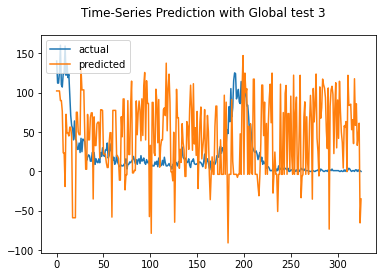

Test MAE: 89.893
Test RMSE: 135.270
Test sMAPE: 165.818
Test R Squared: -15.842
{'mae': 89.89321521573638, 'rmse': 135.27014161974202, 'smape': 165.8175685363819, 'r2': -15.841869800406343}


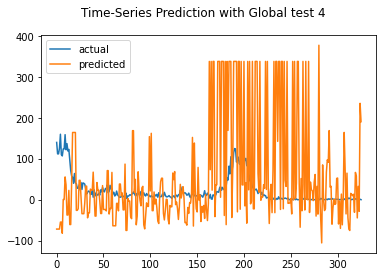

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 46.246
Test RMSE: 55.000
Test sMAPE: 134.853
Test R Squared: -1.784
{'mae': 46.24584210229798, 'rmse': 55.00025815843884, 'smape': 134.8526605177527, 'r2': -1.784299004836556}


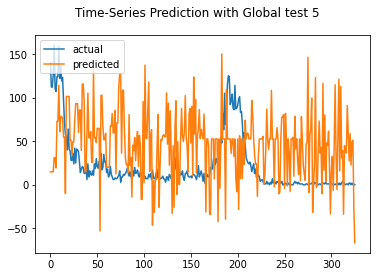

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 45.737
Test RMSE: 58.645
Test sMAPE: 133.519
Test R Squared: -2.166
{'mae': 45.736792617140374, 'rmse': 58.64487647697093, 'smape': 133.51914933355644, 'r2': -2.165530978422938}


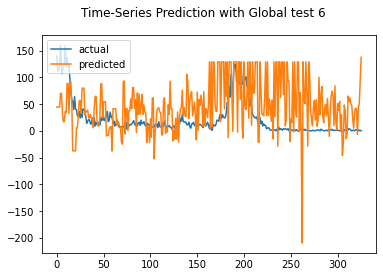

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 45.275
Test RMSE: 51.566
Test sMAPE: 131.594
Test R Squared: -1.447
{'mae': 45.27547072843174, 'rmse': 51.56563456637614, 'smape': 131.59396727557797, 'r2': -1.4474123617279235}


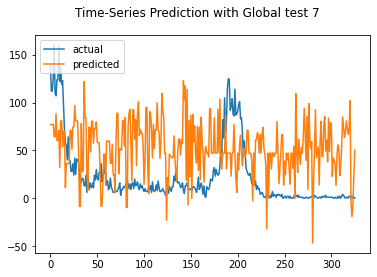

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 48.633
Test RMSE: 55.558
Test sMAPE: 130.047
Test R Squared: -1.841
{'mae': 48.63271037091507, 'rmse': 55.55796676479133, 'smape': 130.04691903079453, 'r2': -1.8410514816417862}


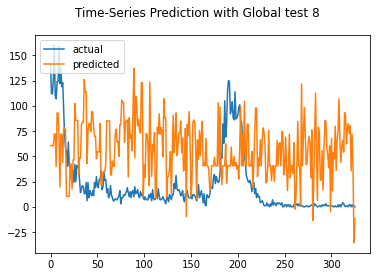

Test MAE: 62.547
Test RMSE: 70.484
Test sMAPE: 135.517
Test R Squared: -3.573
{'mae': 62.547308063214544, 'rmse': 70.48388899859752, 'smape': 135.51720761060827, 'r2': -3.57263075836884}


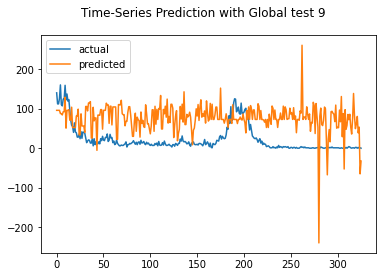

Test MAE: 52.147
Test RMSE: 60.296
Test sMAPE: 131.832
Test R Squared: -2.346
{'mae': 52.14738304044571, 'rmse': 60.29618622019301, 'smape': 131.83240791922256, 'r2': -2.3463094765509576}


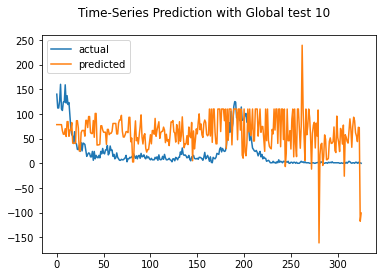

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 46.020
Test RMSE: 54.757
Test sMAPE: 130.261
Test R Squared: -1.760
{'mae': 46.01986819523975, 'rmse': 54.75665378142143, 'smape': 130.2610955107877, 'r2': -1.7596894712386075}


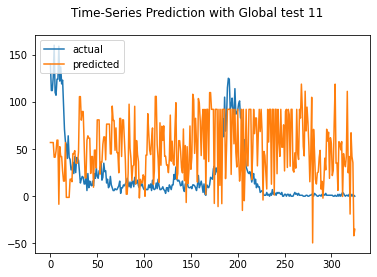

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 42.619
Test RMSE: 52.920
Test sMAPE: 134.775
Test R Squared: -1.578
{'mae': 42.61948110035227, 'rmse': 52.92011742938661, 'smape': 134.77524863792974, 'r2': -1.5776741402905134}


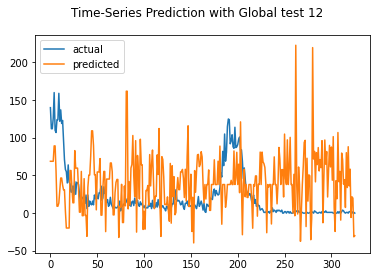

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 55.590
Test RMSE: 66.861
Test sMAPE: 137.891
Test R Squared: -3.115
{'mae': 55.59042598425977, 'rmse': 66.86099994111333, 'smape': 137.89087739274208, 'r2': -3.11464291154126}


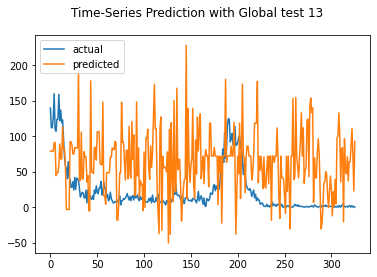

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 47.325
Test RMSE: 54.499
Test sMAPE: 131.248
Test R Squared: -1.734
{'mae': 47.32500353290991, 'rmse': 54.49883338868767, 'smape': 131.2482893057087, 'r2': -1.7337627893111418}


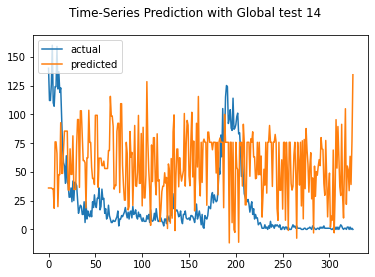

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 43.467
Test RMSE: 52.132
Test sMAPE: 132.006
Test R Squared: -1.501
{'mae': 43.46690837993212, 'rmse': 52.13168124822391, 'smape': 132.00643451946272, 'r2': -1.5014387804309965}


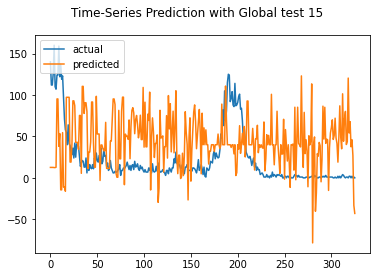

Test MAE: 45.036
Test RMSE: 58.524
Test sMAPE: 135.194
Test R Squared: -2.153
{'mae': 45.036492749043035, 'rmse': 58.52447196139102, 'smape': 135.1941487225692, 'r2': -2.152545940992844}


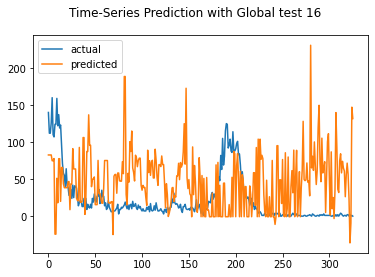

Test MAE: 87.077
Test RMSE: 104.484
Test sMAPE: 153.065
Test R Squared: -9.048
{'mae': 87.07708671798736, 'rmse': 104.48429128246464, 'smape': 153.06519500798404, 'r2': -9.048203424001766}


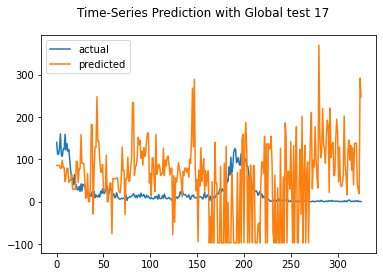

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 39.310
Test RMSE: 49.844
Test sMAPE: 132.202
Test R Squared: -1.287
{'mae': 39.30953322195568, 'rmse': 49.843936283326215, 'smape': 132.20150827650076, 'r2': -1.2867099451958315}


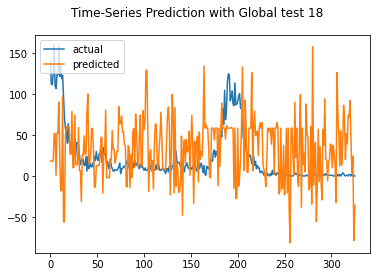

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 49.225
Test RMSE: 60.895
Test sMAPE: 133.454
Test R Squared: -2.413
{'mae': 49.22453214091026, 'rmse': 60.89530605762975, 'smape': 133.45370001176914, 'r2': -2.4131395978054377}


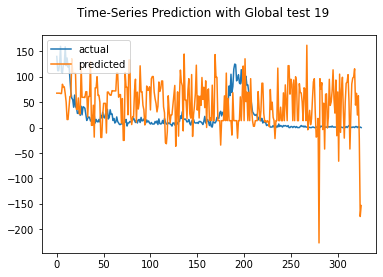

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 63.808
Test RMSE: 74.605
Test sMAPE: 137.851
Test R Squared: -4.123
{'mae': 63.80823099978863, 'rmse': 74.60529565312575, 'smape': 137.85074650135942, 'r2': -4.12301618298404}


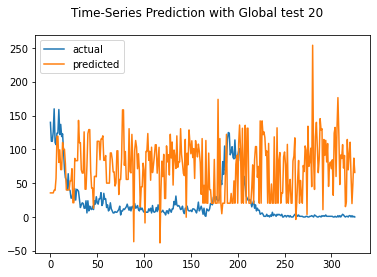

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 53.203
Test RMSE: 68.628
Test sMAPE: 155.947
Test R Squared: -3.335
{'mae': 53.20302931808987, 'rmse': 68.62755610958472, 'smape': 155.94716134423862, 'r2': -3.3349439179548517}


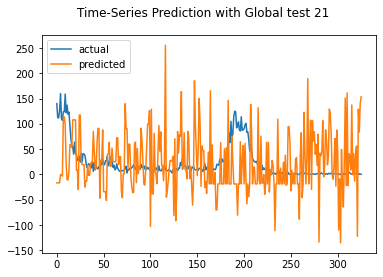

Test MAE: 137.189
Test RMSE: 160.438
Test sMAPE: 163.247
Test R Squared: -22.692
{'mae': 137.18889231769586, 'rmse': 160.43782506970555, 'smape': 163.24665275728444, 'r2': -22.69190312313299}


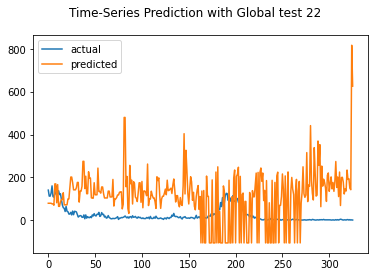

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 44.626
Test RMSE: 53.181
Test sMAPE: 131.496
Test R Squared: -1.603
{'mae': 44.6259223899227, 'rmse': 53.1808013803601, 'smape': 131.49550662245628, 'r2': -1.6031318808133994}


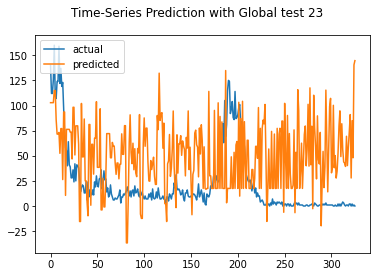

Test MAE: 47.730
Test RMSE: 67.221
Test sMAPE: 129.385
Test R Squared: -3.159
{'mae': 47.72983161529149, 'rmse': 67.22145850278281, 'smape': 129.38482518392317, 'r2': -3.1591279249604503}


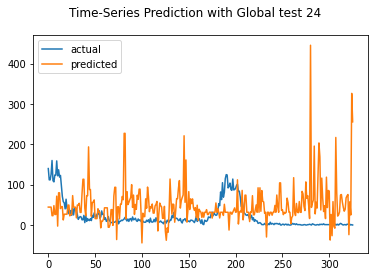

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 51.065
Test RMSE: 64.469
Test sMAPE: 143.383
Test R Squared: -2.826
{'mae': 51.06531735194241, 'rmse': 64.46916630286745, 'smape': 143.38339746006517, 'r2': -2.825520418775379}


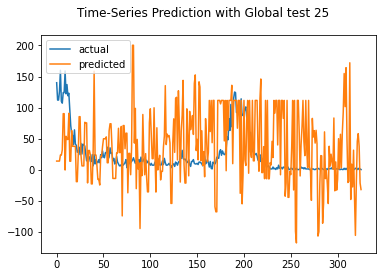

Test MAE: 79.733
Test RMSE: 102.088
Test sMAPE: 140.536
Test R Squared: -8.593
{'mae': 79.73257302872243, 'rmse': 102.08832236825735, 'smape': 140.53579864845136, 'r2': -8.59264892526626}


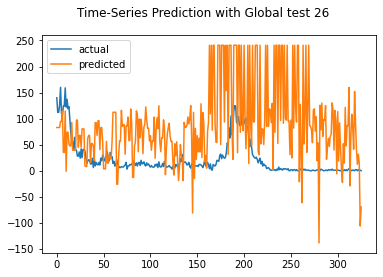

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 56.863
Test RMSE: 71.874
Test sMAPE: 139.116
Test R Squared: -3.755
{'mae': 56.86346430573727, 'rmse': 71.87421691241279, 'smape': 139.11569168175905, 'r2': -3.7548045340550003}


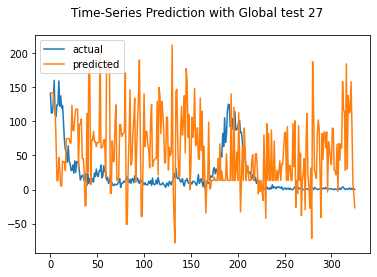

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 45.759
Test RMSE: 63.001
Test sMAPE: 125.062
Test R Squared: -2.653
{'mae': 45.758708387156204, 'rmse': 63.00127106032968, 'smape': 125.06189379771185, 'r2': -2.6532974961027747}


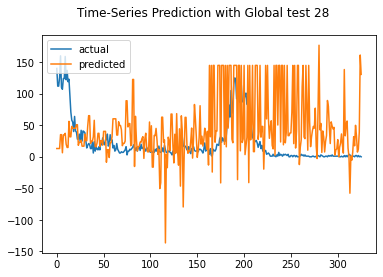

Test MAE: 55.814
Test RMSE: 81.019
Test sMAPE: 132.058
Test R Squared: -5.042
{'mae': 55.81428244856237, 'rmse': 81.01949281484688, 'smape': 132.0575846270557, 'r2': -5.041787641882679}


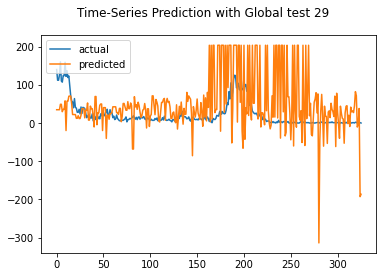

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 44.851
Test RMSE: 61.219
Test sMAPE: 144.713
Test R Squared: -2.450
{'mae': 44.85132982083625, 'rmse': 61.2189887121417, 'smape': 144.71279878326473, 'r2': -2.4495204065317995}


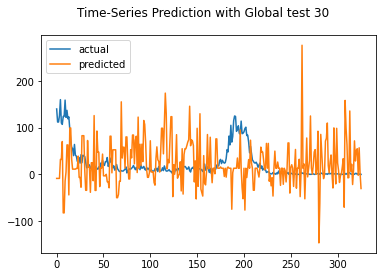

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 49.638
Test RMSE: 63.147
Test sMAPE: 137.746
Test R Squared: -2.670
{'mae': 49.63791626262153, 'rmse': 63.1474689283466, 'smape': 137.74586095071217, 'r2': -2.670272519151448}


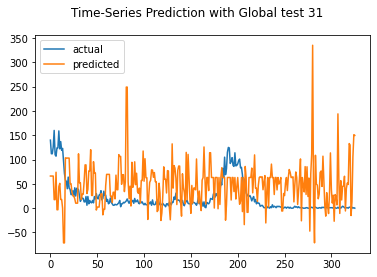

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 38.643
Test RMSE: 50.684
Test sMAPE: 131.355
Test R Squared: -1.364
{'mae': 38.642589848739966, 'rmse': 50.683639591840624, 'smape': 131.35459742973157, 'r2': -1.3644057358694348}


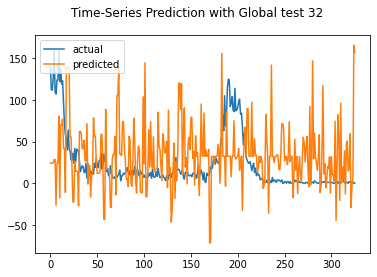

Test MAE: 81.716
Test RMSE: 96.846
Test sMAPE: 140.425
Test R Squared: -7.633
{'mae': 81.71649397333707, 'rmse': 96.84552706864427, 'smape': 140.4253029414152, 'r2': -7.632678167227889}


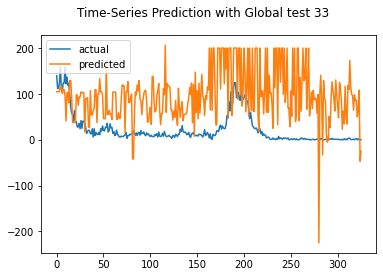

Test MAE: 42.298
Test RMSE: 55.436
Test sMAPE: 134.789
Test R Squared: -1.829
{'mae': 42.29842970031171, 'rmse': 55.43582248158054, 'smape': 134.78920340700614, 'r2': -1.8285731007027044}


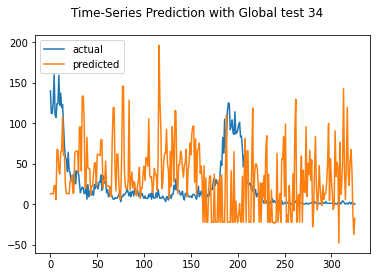

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 54.284
Test RMSE: 65.079
Test sMAPE: 142.972
Test R Squared: -2.898
{'mae': 54.28367008680215, 'rmse': 65.07861199217069, 'smape': 142.97201591273844, 'r2': -2.8981897887771453}


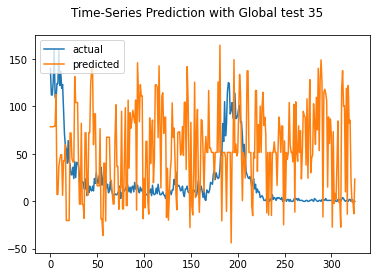

Test MAE: 64.296
Test RMSE: 71.026
Test sMAPE: 138.317
Test R Squared: -3.643
{'mae': 64.29618884010549, 'rmse': 71.02587983970545, 'smape': 138.31748008646298, 'r2': -3.6432242698736035}


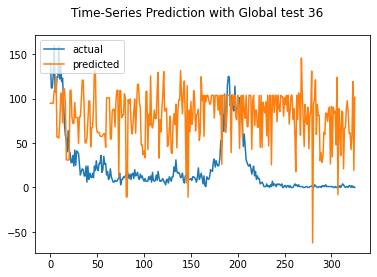

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 41.884
Test RMSE: 53.057
Test sMAPE: 145.542
Test R Squared: -1.591
{'mae': 41.88426968299904, 'rmse': 53.05694444017043, 'smape': 145.54190492670753, 'r2': -1.5910207244784051}


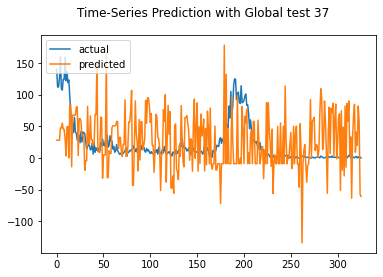

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 46.437
Test RMSE: 56.012
Test sMAPE: 136.999
Test R Squared: -1.888
{'mae': 46.43730712777998, 'rmse': 56.01210885395839, 'smape': 136.9986926169743, 'r2': -1.8876879759840492}


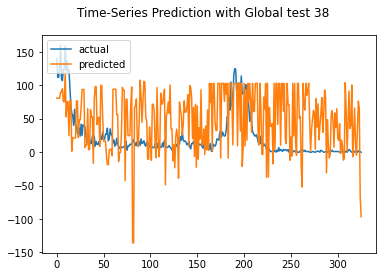

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 53.616
Test RMSE: 63.420
Test sMAPE: 133.066
Test R Squared: -2.702
{'mae': 53.61600477015314, 'rmse': 63.419691948673005, 'smape': 133.06590301046324, 'r2': -2.701985152224819}


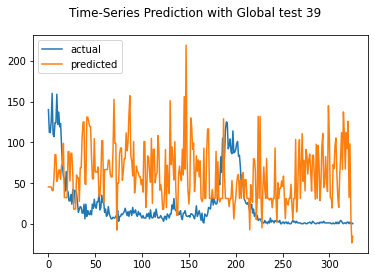

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 46.196
Test RMSE: 54.571
Test sMAPE: 129.342
Test R Squared: -1.741
{'mae': 46.195753852282564, 'rmse': 54.57064576154923, 'smape': 129.3415403641337, 'r2': -1.7409720201626304}


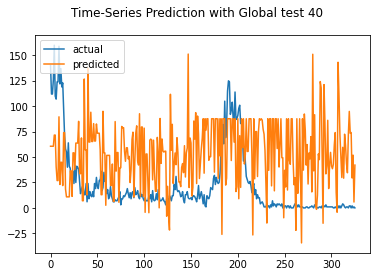

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 49.335
Test RMSE: 58.265
Test sMAPE: 135.758
Test R Squared: -2.125
{'mae': 49.3354554213812, 'rmse': 58.26535736666284, 'smape': 135.75758715034056, 'r2': -2.1246922139417332}


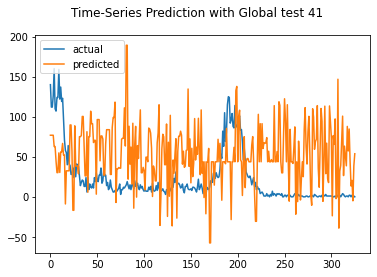

Test MAE: 67.384
Test RMSE: 96.668
Test sMAPE: 151.512
Test R Squared: -7.601
{'mae': 67.38439798172266, 'rmse': 96.66841252743362, 'smape': 151.5118406237212, 'r2': -7.601131543252135}


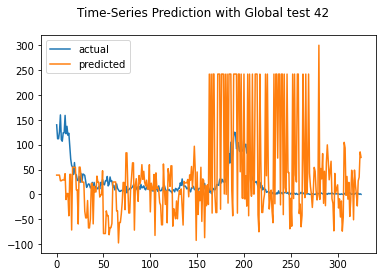

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 50.261
Test RMSE: 58.562
Test sMAPE: 132.806
Test R Squared: -2.157
{'mae': 50.26064997874886, 'rmse': 58.562005964527486, 'smape': 132.80614250352008, 'r2': -2.156590936507412}


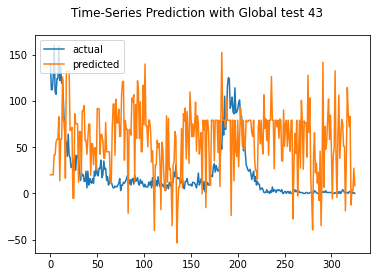

Test MAE: 64.935
Test RMSE: 81.687
Test sMAPE: 148.354
Test R Squared: -5.142
{'mae': 64.93533814977283, 'rmse': 81.68701786849557, 'smape': 148.35413889579118, 'r2': -5.141755161848597}


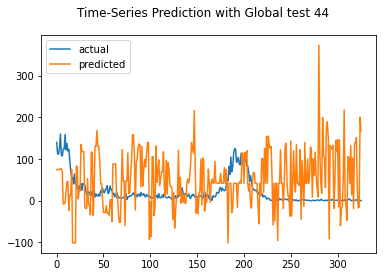

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 54.900
Test RMSE: 66.295
Test sMAPE: 130.469
Test R Squared: -3.045
{'mae': 54.89951308592697, 'rmse': 66.2945535323298, 'smape': 130.46914574264073, 'r2': -3.04521972754521}


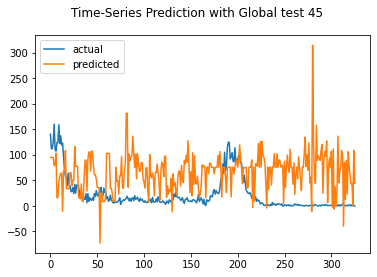

Test MAE: 47.834
Test RMSE: 55.358
Test sMAPE: 132.703
Test R Squared: -1.821
{'mae': 47.834141725228605, 'rmse': 55.3581449853419, 'smape': 132.70330592585472, 'r2': -1.820651777212948}


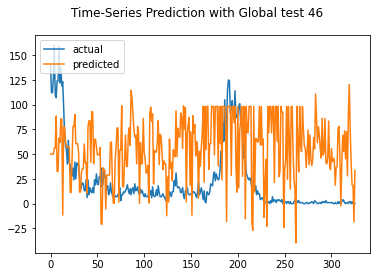

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 49.149
Test RMSE: 56.337
Test sMAPE: 130.337
Test R Squared: -1.921
{'mae': 49.1486593250848, 'rmse': 56.33658548333766, 'smape': 130.33726623481434, 'r2': -1.9212414790134806}


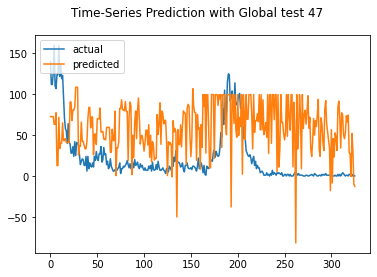

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 54.148
Test RMSE: 67.497
Test sMAPE: 136.923
Test R Squared: -3.193
{'mae': 54.14799026532407, 'rmse': 67.49712977705113, 'smape': 136.92313260906204, 'r2': -3.19331055330825}


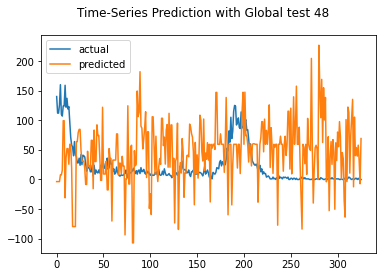

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 49.997
Test RMSE: 59.331
Test sMAPE: 126.185
Test R Squared: -2.240
{'mae': 49.996702113125956, 'rmse': 59.33085127242627, 'smape': 126.18505104854589, 'r2': -2.2400191373253175}


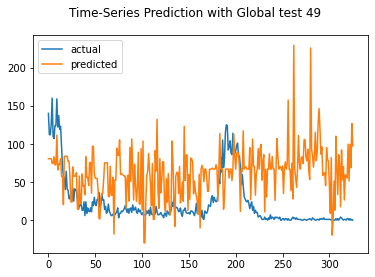

Test MAE: 41.206
Test RMSE: 51.016
Test sMAPE: 127.575
Test R Squared: -1.396
{'mae': 41.20592008521952, 'rmse': 51.01609548943936, 'smape': 127.5749224027625, 'r2': -1.3955257853869973}


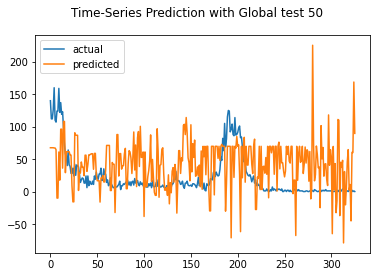

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 50.245
Test RMSE: 60.928
Test sMAPE: 141.582
Test R Squared: -2.417
{'mae': 50.245021639426064, 'rmse': 60.928067248882826, 'smape': 141.58184513284874, 'r2': -2.416813069707168}


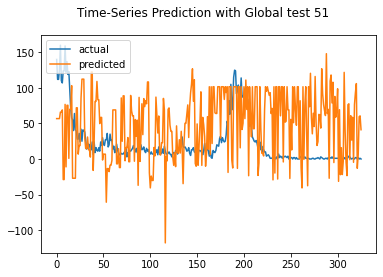

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 43.508
Test RMSE: 54.748
Test sMAPE: 139.465
Test R Squared: -1.759
{'mae': 43.508081415131045, 'rmse': 54.74792560084637, 'smape': 139.46485826666822, 'r2': -1.7588097553816286}


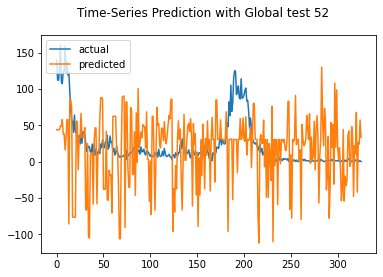

Test MAE: 48.788
Test RMSE: 58.880
Test sMAPE: 136.946
Test R Squared: -2.191
{'mae': 48.7883421663492, 'rmse': 58.880491685037704, 'smape': 136.945890983653, 'r2': -2.1910181331598637}


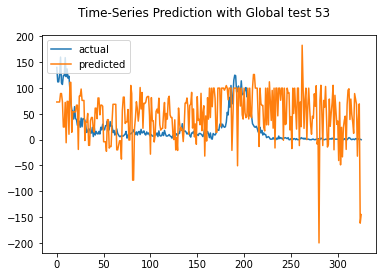

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 66.600
Test RMSE: 80.877
Test sMAPE: 137.691
Test R Squared: -5.021
{'mae': 66.60041625340658, 'rmse': 80.87680307710178, 'smape': 137.6909499223044, 'r2': -5.020525056607896}


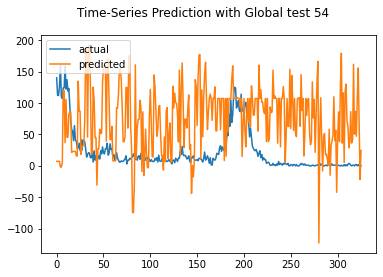

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 37.089
Test RMSE: 45.210
Test sMAPE: 125.949
Test R Squared: -0.881
{'mae': 37.08916522096271, 'rmse': 45.21020622915599, 'smape': 125.94949591154942, 'r2': -0.8813057913424418}


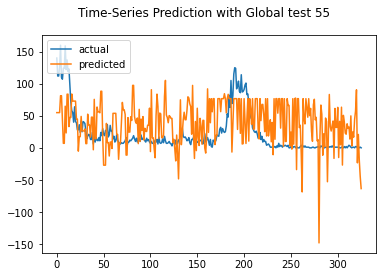

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 64.279
Test RMSE: 79.861
Test sMAPE: 140.802
Test R Squared: -4.870
{'mae': 64.27945991089008, 'rmse': 79.8613331523378, 'smape': 140.80209360577132, 'r2': -4.870289610830119}


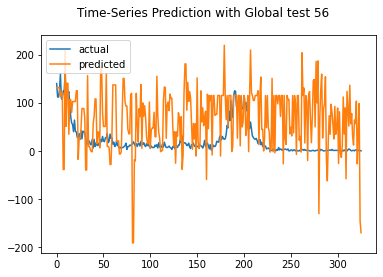

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 47.918
Test RMSE: 62.574
Test sMAPE: 143.305
Test R Squared: -2.604
{'mae': 47.918078526854515, 'rmse': 62.57420890790014, 'smape': 143.3052874661547, 'r2': -2.603936678165351}


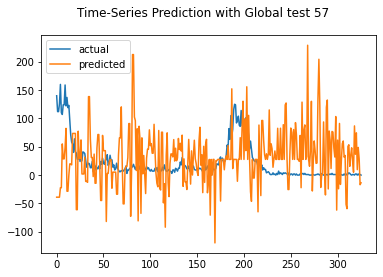

Test MAE: 84.775
Test RMSE: 107.726
Test sMAPE: 158.687
Test R Squared: -9.681
{'mae': 84.77450361244517, 'rmse': 107.72629667033246, 'smape': 158.68670467179234, 'r2': -9.681441757232054}


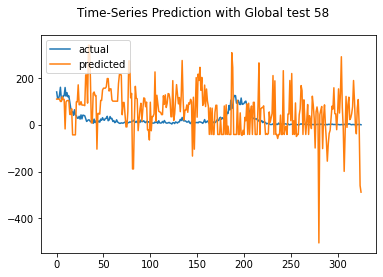

Test MAE: 59.050
Test RMSE: 70.597
Test sMAPE: 137.874
Test R Squared: -3.587
{'mae': 59.05007711948792, 'rmse': 70.59696568899668, 'smape': 137.87420634490599, 'r2': -3.5873141907309014}


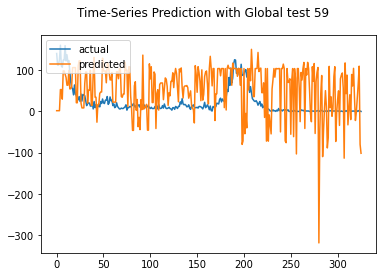

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 41.599
Test RMSE: 54.485
Test sMAPE: 126.287
Test R Squared: -1.732
{'mae': 41.598775266869666, 'rmse': 54.48514520605524, 'smape': 126.287164222255, 'r2': -1.7323897123960843}


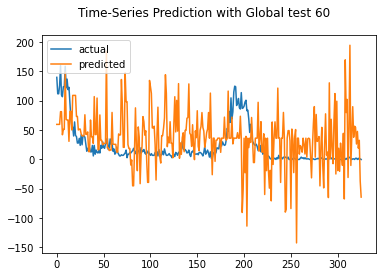

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 50.397
Test RMSE: 64.571
Test sMAPE: 136.928
Test R Squared: -2.838
{'mae': 50.39690893376532, 'rmse': 64.5714322991908, 'smape': 136.92843531596333, 'r2': -2.8376667197692647}


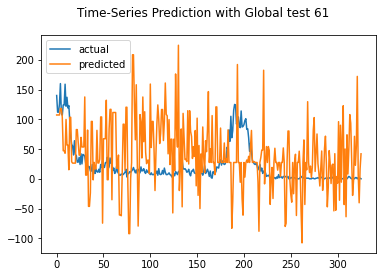

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 45.787
Test RMSE: 55.423
Test sMAPE: 137.107
Test R Squared: -1.827
{'mae': 45.78661308277604, 'rmse': 55.423145261682514, 'smape': 137.10730716114992, 'r2': -1.8272795565110473}


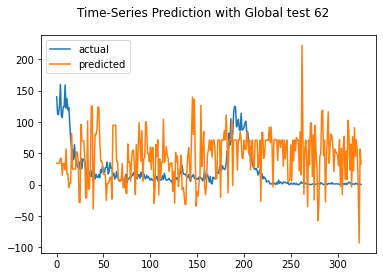

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 36.272
Test RMSE: 44.345
Test sMAPE: 125.381
Test R Squared: -0.810
{'mae': 36.271654402002966, 'rmse': 44.34463775050846, 'smape': 125.38117961181018, 'r2': -0.8099585919716685}


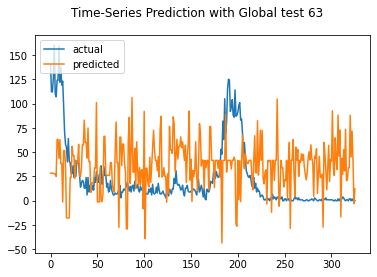

Test MAE: 63.350
Test RMSE: 71.982
Test sMAPE: 141.216
Test R Squared: -3.769
{'mae': 63.350148162593136, 'rmse': 71.98234069132164, 'smape': 141.21618277828256, 'r2': -3.7691210484976816}


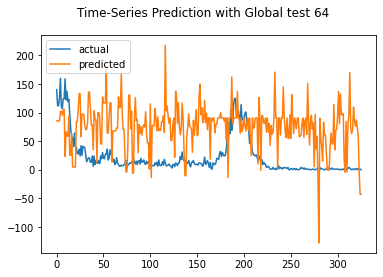

Test MAE: 45.766
Test RMSE: 61.085
Test sMAPE: 145.308
Test R Squared: -2.434
{'mae': 45.7662958756912, 'rmse': 61.08498910493402, 'smape': 145.30773611770016, 'r2': -2.4344359202708254}


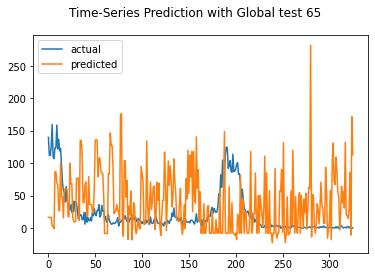

Test MAE: 70.644
Test RMSE: 99.032
Test sMAPE: 146.684
Test R Squared: -8.027
{'mae': 70.64413050978096, 'rmse': 99.0315401449277, 'smape': 146.68383984946132, 'r2': -8.026792985884567}


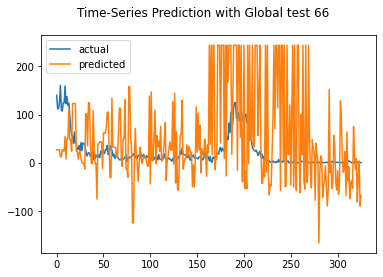

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 46.761
Test RMSE: 57.000
Test sMAPE: 138.315
Test R Squared: -1.990
{'mae': 46.760760827664214, 'rmse': 56.9995815026156, 'smape': 138.315343037319, 'r2': -1.9904032105621918}


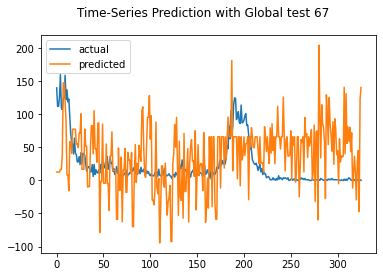

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 49.282
Test RMSE: 55.376
Test sMAPE: 131.927
Test R Squared: -1.822
{'mae': 49.281918157280586, 'rmse': 55.37599434169577, 'smape': 131.92749073664123, 'r2': -1.8224710193678946}


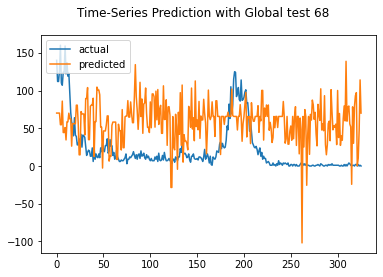

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 45.044
Test RMSE: 55.037
Test sMAPE: 135.857
Test R Squared: -1.788
{'mae': 45.04363430405687, 'rmse': 55.036568252630566, 'smape': 135.85678489823692, 'r2': -1.7879764977801482}


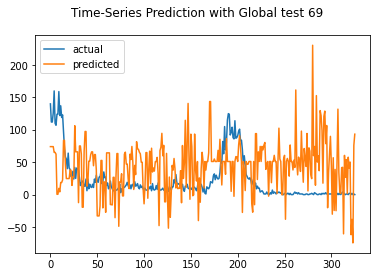

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 39.648
Test RMSE: 52.422
Test sMAPE: 130.036
Test R Squared: -1.529
{'mae': 39.648041756240865, 'rmse': 52.42190506116109, 'smape': 130.03613442270535, 'r2': -1.5293679738683985}


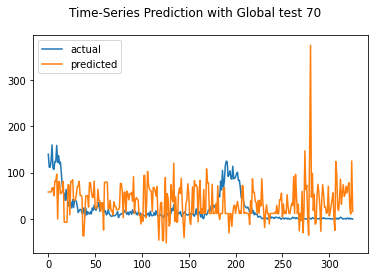

Test MAE: 67.641
Test RMSE: 76.356
Test sMAPE: 139.620
Test R Squared: -4.366
{'mae': 67.6411459358192, 'rmse': 76.35603006394602, 'smape': 139.61990381484134, 'r2': -4.366277125568637}


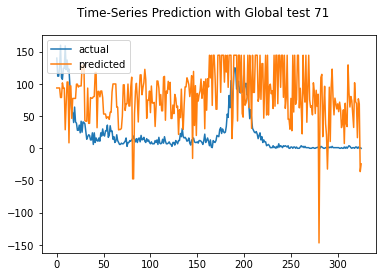

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 54.890
Test RMSE: 69.293
Test sMAPE: 137.651
Test R Squared: -3.419
{'mae': 54.890279433478604, 'rmse': 69.29294158752509, 'smape': 137.65087456681113, 'r2': -3.4194112058692046}


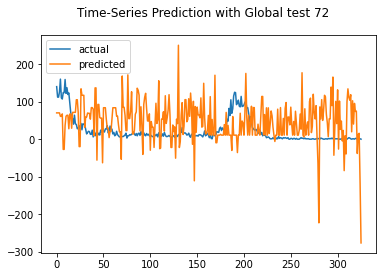

Test MAE: 63.298
Test RMSE: 73.913
Test sMAPE: 151.879
Test R Squared: -4.028
{'mae': 63.298157698903346, 'rmse': 73.91330749625247, 'smape': 151.87933699281797, 'r2': -4.028421672553251}


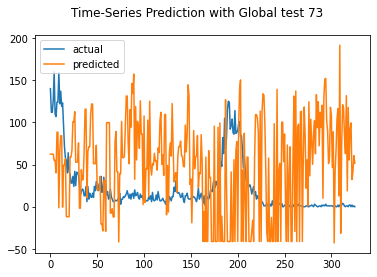

Test MAE: 52.004
Test RMSE: 61.809
Test sMAPE: 130.992
Test R Squared: -2.516
{'mae': 52.00437346411629, 'rmse': 61.80865638979817, 'smape': 130.99207400102708, 'r2': -2.5162927240933484}


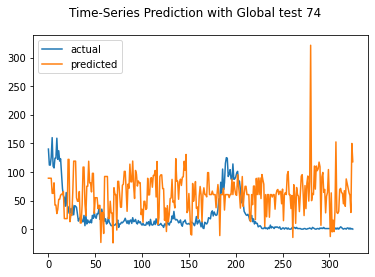

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 49.022
Test RMSE: 61.670
Test sMAPE: 130.093
Test R Squared: -2.501
{'mae': 49.02229964093197, 'rmse': 61.67021455405152, 'smape': 130.09269174219293, 'r2': -2.500558460722761}


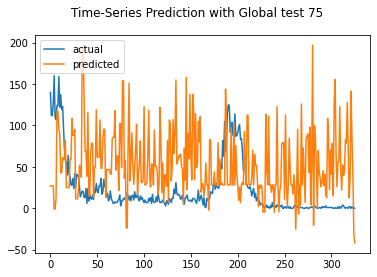

Test MAE: 54.459
Test RMSE: 62.945
Test sMAPE: 134.349
Test R Squared: -2.647
{'mae': 54.459354886248065, 'rmse': 62.94518786853041, 'smape': 134.34912025079893, 'r2': -2.6467961228544046}


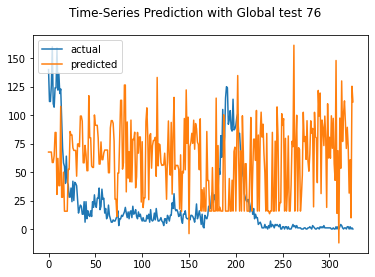

Test MAE: 111.213
Test RMSE: 127.363
Test sMAPE: 171.574
Test R Squared: -13.930
{'mae': 111.21339706555466, 'rmse': 127.36307459573605, 'smape': 171.57416805545495, 'r2': -13.930470210907606}


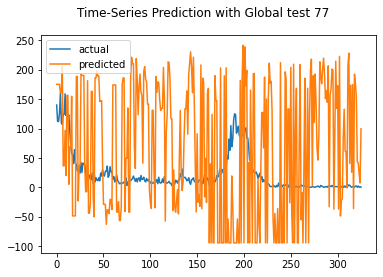

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 52.310
Test RMSE: 63.954
Test sMAPE: 129.407
Test R Squared: -2.765
{'mae': 52.31027809864173, 'rmse': 63.95435172145053, 'smape': 129.40655734814115, 'r2': -2.764667443330529}


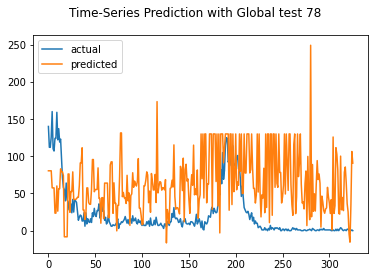

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 44.771
Test RMSE: 54.642
Test sMAPE: 132.274
Test R Squared: -1.748
{'mae': 44.77104887475997, 'rmse': 54.64242277068608, 'smape': 132.27421589692725, 'r2': -1.74818718709616}


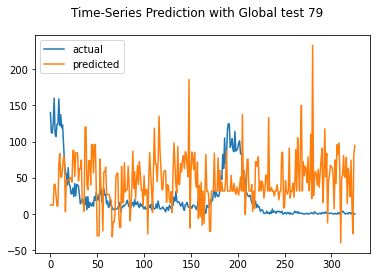

Test MAE: 58.559
Test RMSE: 89.909
Test sMAPE: 162.451
Test R Squared: -6.440
{'mae': 58.55941625222838, 'rmse': 89.90943883316362, 'smape': 162.4508205622926, 'r2': -6.4404120988582845}


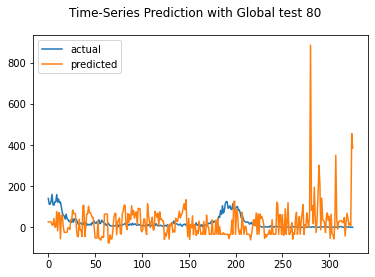

Test MAE: 42.496
Test RMSE: 55.386
Test sMAPE: 148.632
Test R Squared: -1.823
{'mae': 42.49611246622413, 'rmse': 55.385743957984964, 'smape': 148.63213733222588, 'r2': -1.8234649674565282}


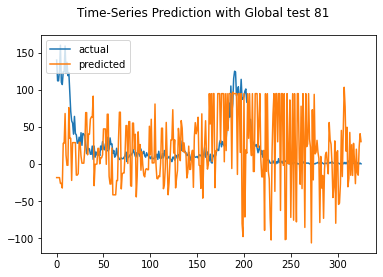

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 37.900
Test RMSE: 49.487
Test sMAPE: 126.743
Test R Squared: -1.254
{'mae': 37.900252172917675, 'rmse': 49.486553206452896, 'smape': 126.7430145379951, 'r2': -1.254035894736917}


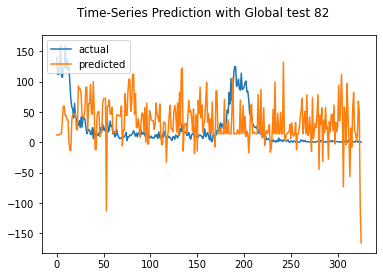

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 39.797
Test RMSE: 47.515
Test sMAPE: 125.841
Test R Squared: -1.078
{'mae': 39.79677153035907, 'rmse': 47.514590957164685, 'smape': 125.84147592894175, 'r2': -1.0779754194862905}


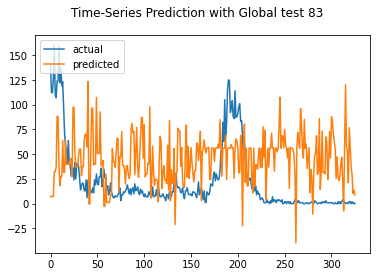

Test MAE: 86.099
Test RMSE: 96.031
Test sMAPE: 154.522
Test R Squared: -7.488
{'mae': 86.09865557352093, 'rmse': 96.03105411635977, 'smape': 154.52232345340317, 'r2': -7.488086727513556}


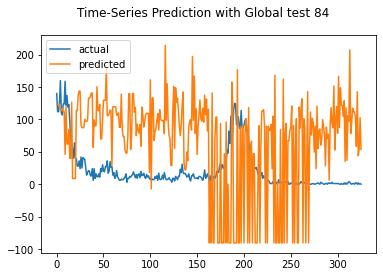

Test MAE: 70.717
Test RMSE: 82.019
Test sMAPE: 137.217
Test R Squared: -5.192
{'mae': 70.7169803344399, 'rmse': 82.01858133210429, 'smape': 137.21699081527203, 'r2': -5.191714493262626}


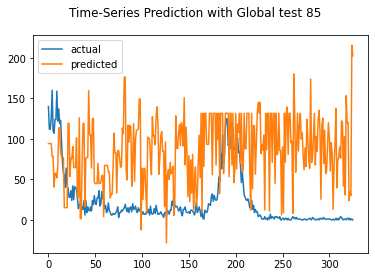

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 45.430
Test RMSE: 57.497
Test sMAPE: 129.663
Test R Squared: -2.043
{'mae': 45.42994191118179, 'rmse': 57.4968199856803, 'smape': 129.66327833166181, 'r2': -2.0428046221940854}


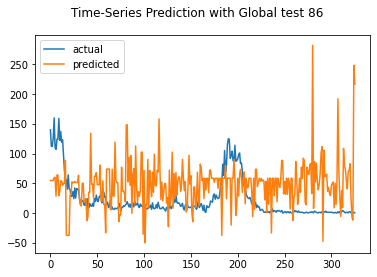

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 45.482
Test RMSE: 57.785
Test sMAPE: 129.601
Test R Squared: -2.073
{'mae': 45.48163235150963, 'rmse': 57.78492083232737, 'smape': 129.60088639592155, 'r2': -2.0733743433087004}


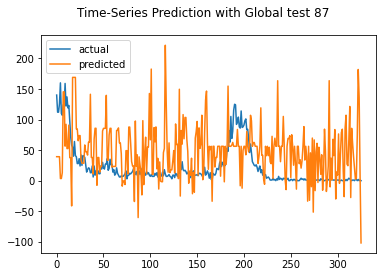

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 57.182
Test RMSE: 73.113
Test sMAPE: 145.308
Test R Squared: -3.920
{'mae': 57.18165609615346, 'rmse': 73.11267009824896, 'smape': 145.30835632388167, 'r2': -3.9200748038992668}


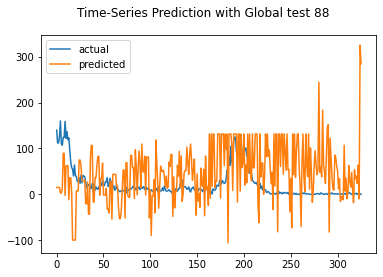

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 37.400
Test RMSE: 47.776
Test sMAPE: 131.013
Test R Squared: -1.101
{'mae': 37.39970699519468, 'rmse': 47.7755990961352, 'smape': 131.0133998205291, 'r2': -1.100867678940209}


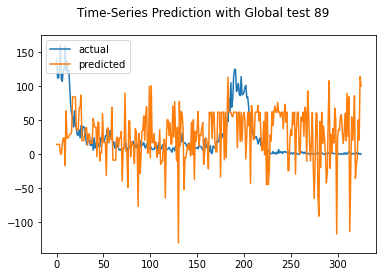

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 42.319
Test RMSE: 56.424
Test sMAPE: 142.019
Test R Squared: -1.930
{'mae': 42.318758410910156, 'rmse': 56.423838057461936, 'smape': 142.01879297859253, 'r2': -1.9302971651764818}


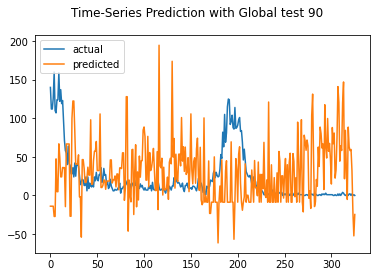

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 49.988
Test RMSE: 65.246
Test sMAPE: 141.699
Test R Squared: -2.918
{'mae': 49.987526794335594, 'rmse': 65.24554905817592, 'smape': 141.69866202796126, 'r2': -2.918214401723298}


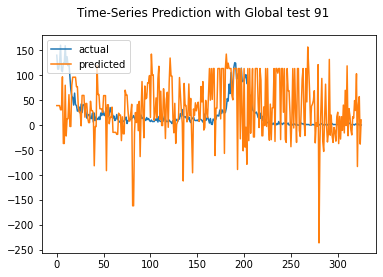

Test MAE: 85.741
Test RMSE: 96.398
Test sMAPE: 152.286
Test R Squared: -7.553
{'mae': 85.74091473752004, 'rmse': 96.39847947883206, 'smape': 152.28612459639274, 'r2': -7.5531636901494}


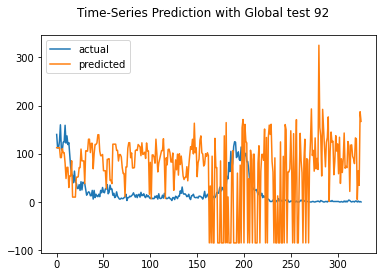

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 44.463
Test RMSE: 56.569
Test sMAPE: 131.690
Test R Squared: -1.945
{'mae': 44.46338302463842, 'rmse': 56.569334045029215, 'smape': 131.69005467255133, 'r2': -1.9454289317741944}


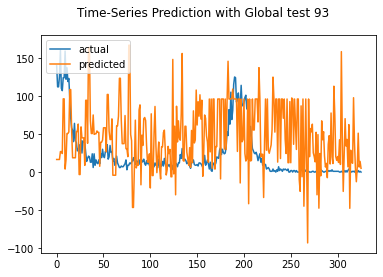

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 56.696
Test RMSE: 68.041
Test sMAPE: 140.210
Test R Squared: -3.261
{'mae': 56.69561753609429, 'rmse': 68.04138648421039, 'smape': 140.21046547708235, 'r2': -3.261207920317541}


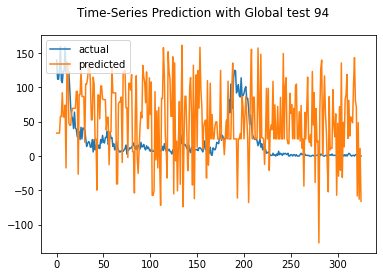

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 45.302
Test RMSE: 56.694
Test sMAPE: 135.689
Test R Squared: -1.958
{'mae': 45.30221166091462, 'rmse': 56.69425855287172, 'smape': 135.68860076946692, 'r2': -1.9584523322709262}


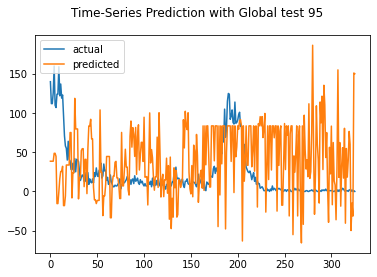

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 66.501
Test RMSE: 74.893
Test sMAPE: 137.555
Test R Squared: -4.163
{'mae': 66.5013089845517, 'rmse': 74.89345322679378, 'smape': 137.55536290685018, 'r2': -4.16266717096214}


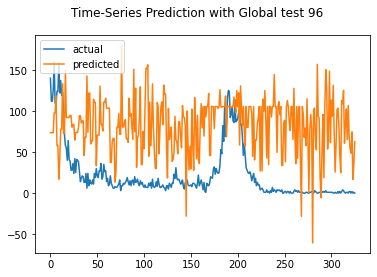

Test MAE: 96.959
Test RMSE: 120.650
Test sMAPE: 153.071
Test R Squared: -12.398
{'mae': 96.95870064226396, 'rmse': 120.65005370061336, 'smape': 153.07058060573627, 'r2': -12.398045715250555}


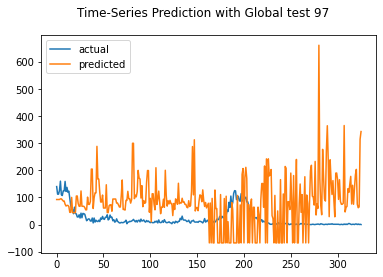

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 39.348
Test RMSE: 52.399
Test sMAPE: 127.929
Test R Squared: -1.527
{'mae': 39.34801688442932, 'rmse': 52.39852321328085, 'smape': 127.92939368102296, 'r2': -1.527112118890476}


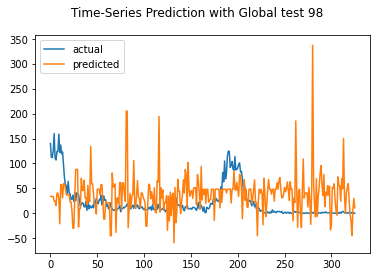

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 39.259
Test RMSE: 49.488
Test sMAPE: 135.285
Test R Squared: -1.254
{'mae': 39.25905341266489, 'rmse': 49.48760816673665, 'smape': 135.28549427943244, 'r2': -1.2541319993770426}


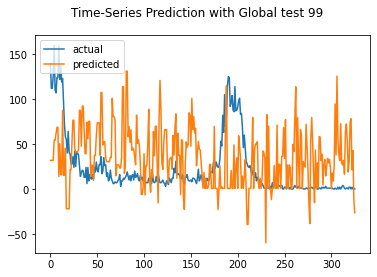

rmse : average=68.673, std=22.170
mae : average=55.546, std=18.272
smape : average=138.342, std=9.686
r2 : average=-3.793, std=3.765


([68.67318871942975, 22.170040272159742],
 [55.545777107060324, 18.272475741048705],
 [138.34244222819567, 9.68601147738064],
 [-3.793107364268535, 3.7648713005869188])

In [13]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
